##### two or three laps of center lane driving
##### one lap of recovery driving from the sides
##### one lap focusing on driving smoothly around curves

In [1]:
import tensorflow as tf
import gc
import time
import csv
import random
import datetime
import sklearn
import cv2 
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Lambda,Cropping2D,Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10576369169545983151
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4951991910
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8124547134361188964
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


### Generator Batch image

In [2]:
samples = []
#read udacity
with open(os.path.join('data','driving_log.csv')) as csvfile:
    reader = csv.reader(csvfile)
    # Skip header row.
    next(reader)
    for line in reader:
        samples.append(line)
        
# read my training data
with open(os.path.join('training_data','driving_log.csv')) as csvfile:
    reader = csv.reader(csvfile)
    # Skip header row.
    next(reader)
    for line in reader:
        samples.append(line)

In [3]:
def read_img(path):
    if (path.__contains__('training_data')):
        filename = path.split('\\')[-1] 
        file_path = os.path.join('training_data', 'IMG', filename)
    else:
        filename = path.split("/")[-1]
        file_path = os.path.join('data', 'IMG', filename)
    image =  mpimg.imread(os.path.join(file_path))
    return image


#Data augmentation
def decrease_brightness(img):
    img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    rand_num = random.uniform(0.6,0.9)
    img_hsv[:,:,2] = rand_num *img_hsv[:,:,2]
    return cv2.cvtColor(img_hsv,cv2.COLOR_HSV2RGB)

def filp_image_angle(img,angle):
 
    flipped_img = cv2.flip(img,1)
    filpped_angle = angle*(-1.0)
    return flipped_img, filpped_angle



def get_processed_image_angle(img_path,angle_in_csv):
    image = read_img(img_path)             
    angle = float(angle_in_csv)
      # random decrease brightness or flip
    img_random_bright = random_decrease_brightness(image)
    img_random_flip,angle = random_filp(img_random_bright,angle)
    processed_img = cv2.cvtColor(img_random_flip, cv2.COLOR_RGB2YUV)
    return processed_img,angle

### LOAD ALL DATA IN ONE TIME (NOT USING GENARATORS)

In [4]:

def load_data(samples,training_data=True):
    images = []
    angles = []
    center_image_keep_rate = 0.8
    correction = 0.23
    
    for sample in samples:
        center_image = read_img(sample[0])
        center_angle = float(sample[3])
        if np.random.random()  < center_image_keep_rate:
            
            images.append(center_image)
            angles.append(center_angle)
            # if this steel wheel turns add right left camerea images
        if center_angle != 0:
            left_image = read_img(sample[1])
            left_angle = center_angle + correction
            right_image = read_img(sample[2])
            right_angle = center_angle - correction
            images.append(left_image)
            images.append(right_image)
            angles.append(left_angle)
            angles.append(right_angle)
    return images, angles

def random_augment(images,angles):
    random_decrease_brightness_rate = 0.3
    augmented_images = images.copy()
    augmented_angles = angles.copy()
    
    for image, angle in zip (images,angles):
        
        if angle !=0:
            flipped_image,flipped_angle = filp_image_angle(image,angle)
            augmented_images.append(flipped_image)
            augmented_angles.append(flipped_angle)
        #random_decrease_brightness
        if np.random.random()  <random_decrease_brightness_rate:
            dark_image = decrease_brightness(image)
            dark_image_angle = angle
            augmented_images.append(dark_image)
            augmented_angles.append(dark_image_angle)
    X = np.array(augmented_images)
    y = np.array(augmented_angles)
    return shuffle(X, y)


In [5]:
t0 = time.time()
raw_images,raw_angles = load_data(samples)

X_train,y_train =random_augment(raw_images,raw_angles)
del raw_angles,raw_images
gc.collect()

t1=time.time()
print("total seconds for loading and agumenting: {} sec".format(round(t1-t0)))


total seconds for loading and agumenting: 377 sec


TypeError: must be str, not int

#### GENARATORS

In [6]:
print('augmented images size:' +str(X_train.shape[0]) +"augmented angle size:" + str(y_train.shape[0]))


augmented images size:48134augmented angle size:48134


In [6]:
def generator(samples,use_other_cameras=False, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):

            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
           
            
            for batch_sample in batch_samples:
                # get center, left,right images
                center_image,center_angle = get_processed_image_angle(batch_sample[0],batch_sample[3])             
    
                if use_other_cameras:
                    correction = 0.25 
                    left_image,left_angle = get_processed_image_angle(batch_sample[1],center_angle + correction)   
                    right_image,right_angle = get_processed_image_angle(batch_sample[2],center_angle - correction)   
                    images.append(left_image)
                    images.append(right_image)
                    angles.append(left_angle)
                    angles.append(right_angle)
            images.append(center_image)
            angles.append(center_angle)
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples,is_valid_data=True, batch_size=BATCH_SIZE)

NameError: name 'train_samples' is not defined

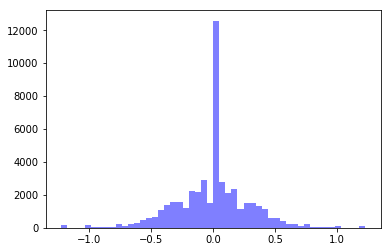

In [8]:
num_bins=50
n, bins, patches = plt.hist(y_train, num_bins, facecolor='blue', alpha=0.5)
plt.savefig('hist_angles.png')
plt.show()

In [11]:
def displayAndSaveImage(image, angle, label):
    plt.imshow(image)
    plt.xlabel("angle: {:.3f}".format(angle))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join("augmented_image_examples",label + ".png"))
    plt.show()

### Example images of augmentation

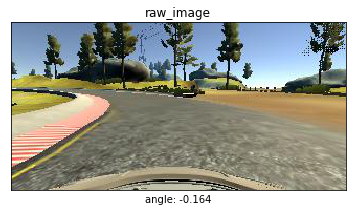

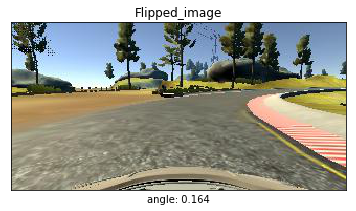

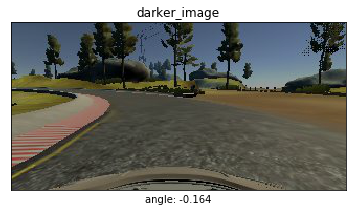

In [12]:
#original image 
image_index = 7000
raw_image = read_img(samples[image_index][0])
raw_image_angle =float(samples[image_index][3])
displayAndSaveImage(raw_image,raw_image_angle,"raw_image")
# flipped image
flipped_image,flipped_angle =filp_image_angle(raw_image,raw_image_angle)
displayAndSaveImage(flipped_image,flipped_angle,"Flipped_image")

# darker image
dark_image =decrease_brightness(raw_image)
displayAndSaveImage(dark_image,raw_image_angle,"darker_image")


### NVIDIA MODEL

In [13]:
def resize_img(image):
    resized = tf.image.resize_images(image, (66, 200))
    return resized

In [ ]:
N_EPOCHS = 256
BATCH_SIZE = 1024
##NVIDIA MODEL
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation
model.add(Cropping2D(cropping=((45,25),(0,0)),input_shape=(160,320,3)))
model.add(Lambda(resize_img))
model.add(Lambda(lambda x:x/255-0.5))
model.add(Conv2D(24,(5,5),strides=(2,2),activation='relu'))
model.add(Dropout(.5))
model.add(Conv2D(36,(5,5),strides=(2,2),activation='relu'))
model.add(Dropout(.5))
model.add(Conv2D(48,(5,5),strides=(2,2),activation='relu'))
model.add(Dropout(.5))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(.5))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1))
model.summary()
checkpoint = ModelCheckpoint('model-{val_loss:03f}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
model.compile(loss='mse', optimizer='Adam')
history_object = model.fit(X_train, y_train,validation_split =0.2,batch_size= BATCH_SIZE,shuffle=True,epochs=N_EPOCHS,callbacks=[checkpoint],verbose = 1)
model_name = 'model_NVIDIA_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.h5'
model.save(model_name)
print("DONE!")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_2 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
dropout_16 (Dropout)         (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 47, 36)        0         
__________

In [61]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig(os.path.join("model_training_validation_epoch.png"))
plt.show()


AttributeError: 'Sequential' object has no attribute 'history'

#### BASE MODEL

In [10]:
model = Sequential()
# normalize and mean centered
model.add(Lambda(lambda x:(x/255.0)-0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((60,25),(0,0))))
model.add(Conv2D(6,3,3,activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(6,3,3,activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))
model.summary()

checkpoint = ModelCheckpoint('model-{val_loss:03f}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
model.compile(loss='mse', optimizer='Adam')
history_object = model.fit(X_train, y_train,validation_split =0.2,shuffle=True,epochs=N_EPOCHS,callbacks=[checkpoint],verbose = 1)
model_name = 'model_WITH_MY_DATA_BASE_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.h5'
model.save(model_name)
print("DONE!")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 106, 6)        168       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 53, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 17, 6)          330       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 8, 6)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 8, 6)           0         
__________

KeyboardInterrupt: 

In [ ]:
history_object_genarator = model.fit_generator(train_generator, steps_per_epoch= STEPS_PER_EPOCH,validation_data=validation_generator,validation_steps=VALIDATION_STEPS, epochs=N_EPOCHS, callbacks=[checkpoint],verbose = 1)
model_name = 'model_fit_genarator'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.h5'
model.save(model_name)
print("DONE!")